In [23]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
1
11.3
cuda


In [2]:
import re
import html

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

In [3]:
import pandas as pd
import nltk
from tqdm import tqdm

nltk.download('punkt')
df = pd.read_csv("KickstarterData.csv")
df = df.dropna(axis = 0)
df["tokenized"] = df["name"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
df = df[(df["state"] == "successful") |(df["state"] == "failed")]
df["hit"] = np.where(df["state"] == "successful", 1, 0)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
print(df[df["hit"] == 1].shape)
print(df[df["hit"] == 0].shape)

(133851, 17)
(197611, 17)


In [5]:
from collections import Counter
PADDING_VALUE = 0
UNK_VALUE     = 1

def split_train_val_test(df, props=[.8, .1, .1]):
    assert round(sum(props), 2) == 1 and len(props) >= 2
    train_df, test_df, val_df = None, None, None

    first_partition = int(df.shape[0] * props[0])
    second_partition = int(df.shape[0] * (props[0] + props[1]))

    train_df = df.iloc[:first_partition,:]
    val_df = df.iloc[first_partition:second_partition,:]
    test_df = df.iloc[second_partition:,:]
    
    return train_df, val_df, test_df

def generate_vocab_map(df, cutoff=2):
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None

    cnt = {}
    for tokens in df["tokenized"]:
      for word in tokens:
        if (word in cnt):
          cnt[word] = cnt[word] + 1
        else:
          cnt[word] = 1

    reversed_vocab = {}
    reversed_vocab[PADDING_VALUE] = ""
    reversed_vocab[UNK_VALUE] = "UNK"
    int_ID = 2
    for word in cnt:
      if (cnt[word] > cutoff):
        vocab[word] = int_ID
        reversed_vocab[int_ID] = word
        int_ID = int_ID + 1
    
    return vocab, reversed_vocab

In [6]:
df                         = df.sample(frac=0.1)
train_df, val_df, test_df  = split_train_val_test(df, props=[.8, .1, .1])
train_vocab, reverse_vocab = generate_vocab_map(train_df)

In [7]:
from torch.utils.data import Dataset

class WordDataset(Dataset):
    
    def __init__(self, vocab, df, max_length=50):
        self.vocab = vocab
        self.df = df
        self.max_length = max_length

        return
    
    # return the length of the dataframe instance variable
    def __len__(self):      
        df_len = self.df.shape[0]
        return df_len

    def __getitem__(self, index: int):
        self.df = self.df.reset_index(drop=True)
        for i in range(len(self.df["tokenized"][index])):
          if not(self.df["tokenized"][index][i] in self.vocab):
            self.df["tokenized"][index][i] = "UNK"

        mapped = []
        for word in self.df["tokenized"][index]:
          if(len(mapped) < self.max_length):
            mapped.append(self.vocab[word])
        tokenized_word_tensor = torch.LongTensor(mapped)
        tokenized_word_tensor = tokenized_word_tensor.to(torch.device(device))

        curr_label = self.df["hit"][index]

        return tokenized_word_tensor, curr_label


In [8]:
from torch.utils.data import RandomSampler

train_dataset = WordDataset(train_vocab, train_df)
val_dataset   = WordDataset(train_vocab, val_df)
test_dataset  = WordDataset(train_vocab, test_df)
 
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

In [9]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, padding_value=PADDING_VALUE):
    padded_tokens, y_labels = None, None

    ptlist = [] # padded_tokens list version
    ylist = []
    for tup in batch:
      ptlist.append(tup[0])
      ylist.append(tup[1])
    padded_tokens = pad_sequence(ptlist, batch_first = True, padding_value = padding_value)
    y_labels = torch.LongTensor(ylist)
    
    return padded_tokens, y_labels

In [10]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [11]:
import torch.nn as nn

class NBOW(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lin_sig = nn.Sequential(
            nn.Linear(embedding_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding_layer(x)
        mean_embed = torch.mean(embedded, axis = 1)
        x_res = self.lin_sig(mean_embed)

        return x_res

In [12]:
model = NBOW(vocab_size = len(train_vocab.keys()), embedding_dim = 300).to(device)

In [13]:
from torch.optim import Adam

criterion = nn.BCELoss().to(torch.device(device))
optimizer = Adam(model.parameters(), lr = 0.003)

In [14]:
def train_loop(model, criterion, optim, iterator):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):

        optim.zero_grad()
        loss = criterion(model.forward(x).reshape(y.shape), y.float().to(torch.device(device)))
        total_loss += loss
        loss.backward()
        optim.step()

    return total_loss

def val_loop(model, iterator):
    true, pred = [], []

    for x, y in tqdm(iterator):
      for tv in y:
        if (tv == 0):
          true.append(False)
        elif (tv == 1):
          true.append(True)
      p = model.forward(x)
      for pv in p:
        if (pv <= 0.5):
          pred.append(False)
        else:
          pred.append(True)

    return true, pred

In [15]:
def accuracy(true, pred):
    acc = None

    same = 0
    for i in range(len(true)):
      if(true[i] == pred[i]):
        same += 1
    acc = same / len(true)

    return acc

def binary_f1(true, pred, selected_class=True):
    f1 = None

    tp = 0 # True Positive
    fp = 0 # False Positive. Actually negative, but predicted to positive
    fn = 0 # False Negative. Actually positive, but predicted to negative
    tn = 0 # True Negative.

    for i in range(len(true)):
      if(true[i] == True) and (pred[i] == True):
        tp = tp + 1
      elif(true[i] == True) and (pred[i] == False):
        fn = fn + 1
      elif(true[i] == False) and (pred[i] == True):
        fp = fp + 1
      elif(true[i] == False) and (pred[i] == False):
        tn = tn + 1
    
    if(selected_class == True):
      precision = tp / (tp + fp + 1)
      recall = tp / (tp + fn + 1)
    elif(selected_class == False):
      precision = tn / (tn + fn + 1)
      recall = tn / (tn + fp + 1)

    f1 = 2 * (precision*recall) / (precision + recall + 1e-10) #prevent zerodivision

    return f1

def binary_macro_f1(true, pred):
    averaged_macro_f1 = 0.5*(binary_f1(true, pred, selected_class=True) + binary_f1(true, pred, selected_class=False))
    return averaged_macro_f1

In [ ]:
TOTAL_EPOCHS = 5
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(model, criterion, optimizer, train_iterator)
    true, pred = val_loop(model, val_iterator)
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")

In [ ]:
df[df["hit"] == 1].shape

In [ ]:
df.shape

# LSTM model

In [16]:
class RecurrentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, \
                 num_layers=1, bidirectional=True):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, bidirectional = bidirectional)
        self.lin_sig = nn.Sequential(
            nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = torch.transpose(embedded, 0, 1)

        outputs, (h, c) = self.lstm(embedded)

        predictions = self.lin_sig(outputs)
        predictions = torch.mean(predictions, axis = 0)
        predictions = predictions.reshape((-1,))

        return predictions
    

In [17]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [18]:
lstm_model = RecurrentModel(vocab_size    = len(train_vocab.keys()),
                            embedding_dim = 300,
                            hidden_dim    = 300,
                            num_layers    = 1,
                            bidirectional = True).to(device)

In [19]:
lstm_criterion = nn.BCELoss().to(torch.device(device))
lstm_optimizer = Adam(lstm_model.parameters(), lr=0.003)

In [20]:
accuracy_plot = []
TOTAL_EPOCHS = 30
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(lstm_model, lstm_criterion, lstm_optimizer, train_iterator)
    true, pred = val_loop(lstm_model, val_iterator)
    accuracy_plot.append(accuracy(true, pred))
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")

100%|██████████| 208/208 [00:01<00:00, 119.04it/s]


EPOCH: 0
TRAIN LOSS: 1075.2413330078125
VAL F-1: 0.5685804533164841
VAL ACC: 0.6289592760180995


100%|██████████| 208/208 [00:01<00:00, 130.20it/s]


EPOCH: 1
TRAIN LOSS: 976.503662109375
VAL F-1: 0.5988481683637019
VAL ACC: 0.633182503770739


100%|██████████| 208/208 [00:01<00:00, 139.68it/s]


EPOCH: 2
TRAIN LOSS: 832.355224609375
VAL F-1: 0.6057402997552858
VAL ACC: 0.6277526395173454


100%|██████████| 208/208 [00:01<00:00, 121.42it/s]


EPOCH: 3
TRAIN LOSS: 666.4716186523438
VAL F-1: 0.5977074037468737
VAL ACC: 0.6099547511312218


100%|██████████| 208/208 [00:01<00:00, 121.52it/s]


EPOCH: 4
TRAIN LOSS: 521.3535766601562
VAL F-1: 0.5974350955285338
VAL ACC: 0.6114630467571645


100%|██████████| 208/208 [00:01<00:00, 143.74it/s]


EPOCH: 5
TRAIN LOSS: 418.7719421386719
VAL F-1: 0.5868491866356917
VAL ACC: 0.5972850678733032


100%|██████████| 208/208 [00:01<00:00, 121.59it/s]


EPOCH: 6
TRAIN LOSS: 357.5799255371094
VAL F-1: 0.5728016271098701
VAL ACC: 0.6048265460030166


100%|██████████| 208/208 [00:01<00:00, 130.41it/s]


EPOCH: 7
TRAIN LOSS: 314.3688659667969
VAL F-1: 0.581587697575056
VAL ACC: 0.6009049773755656


100%|██████████| 208/208 [00:01<00:00, 117.49it/s]


EPOCH: 8
TRAIN LOSS: 288.42974853515625
VAL F-1: 0.5786867302801472
VAL ACC: 0.5957767722473605


100%|██████████| 208/208 [00:01<00:00, 119.57it/s]


EPOCH: 9
TRAIN LOSS: 265.5520324707031
VAL F-1: 0.586384010212455
VAL ACC: 0.6018099547511312


100%|██████████| 208/208 [00:01<00:00, 123.00it/s]


EPOCH: 10
TRAIN LOSS: 255.9941864013672
VAL F-1: 0.5796682366273573
VAL ACC: 0.6


100%|██████████| 208/208 [00:01<00:00, 141.74it/s]


EPOCH: 11
TRAIN LOSS: 257.0727844238281
VAL F-1: 0.5819396621899497
VAL ACC: 0.6036199095022624


100%|██████████| 208/208 [00:01<00:00, 123.94it/s]


EPOCH: 12
TRAIN LOSS: 241.17816162109375
VAL F-1: 0.5862484407415689
VAL ACC: 0.6012066365007541


100%|██████████| 208/208 [00:01<00:00, 111.25it/s]


EPOCH: 13
TRAIN LOSS: 227.02317810058594
VAL F-1: 0.5720056903023583
VAL ACC: 0.5936651583710407


100%|██████████| 208/208 [00:01<00:00, 115.54it/s]


EPOCH: 14
TRAIN LOSS: 221.8616180419922
VAL F-1: 0.5745527440773631
VAL ACC: 0.5906485671191554


100%|██████████| 208/208 [00:01<00:00, 121.91it/s]


EPOCH: 15
TRAIN LOSS: 211.6234893798828
VAL F-1: 0.56920703776859
VAL ACC: 0.5879336349924585


100%|██████████| 208/208 [00:01<00:00, 127.46it/s]


EPOCH: 16
TRAIN LOSS: 215.39613342285156
VAL F-1: 0.5759328044620415
VAL ACC: 0.5972850678733032


100%|██████████| 208/208 [00:01<00:00, 130.72it/s]


EPOCH: 17
TRAIN LOSS: 215.46658325195312
VAL F-1: 0.5779911712567093
VAL ACC: 0.604524886877828


100%|██████████| 208/208 [00:01<00:00, 132.47it/s]


EPOCH: 18
TRAIN LOSS: 215.99246215820312
VAL F-1: 0.5772015170887824
VAL ACC: 0.5984917043740573


100%|██████████| 208/208 [00:01<00:00, 128.43it/s]


EPOCH: 19
TRAIN LOSS: 199.5985565185547
VAL F-1: 0.5750960335683564
VAL ACC: 0.5954751131221719


100%|██████████| 208/208 [00:01<00:00, 119.52it/s]


EPOCH: 20
TRAIN LOSS: 195.6132049560547
VAL F-1: 0.5693557363398061
VAL ACC: 0.5894419306184012


100%|██████████| 208/208 [00:01<00:00, 117.27it/s]


EPOCH: 21
TRAIN LOSS: 198.49472045898438
VAL F-1: 0.5733782440353609
VAL ACC: 0.5945701357466063


100%|██████████| 208/208 [00:01<00:00, 114.53it/s]


EPOCH: 22
TRAIN LOSS: 194.08448791503906
VAL F-1: 0.5818403861841323
VAL ACC: 0.5972850678733032


100%|██████████| 208/208 [00:01<00:00, 133.63it/s]


EPOCH: 23
TRAIN LOSS: 187.73678588867188
VAL F-1: 0.5688199035580682
VAL ACC: 0.5903469079939668


100%|██████████| 208/208 [00:01<00:00, 138.65it/s]


EPOCH: 24
TRAIN LOSS: 195.3265838623047
VAL F-1: 0.5720520872071158
VAL ACC: 0.5963800904977375


100%|██████████| 208/208 [00:02<00:00, 103.14it/s]


EPOCH: 25
TRAIN LOSS: 195.0481719970703
VAL F-1: 0.5668003036706871
VAL ACC: 0.5855203619909503


100%|██████████| 208/208 [00:01<00:00, 119.57it/s]


EPOCH: 26
TRAIN LOSS: 187.36607360839844
VAL F-1: 0.5771021584576231
VAL ACC: 0.5918552036199095


100%|██████████| 208/208 [00:01<00:00, 146.47it/s]


EPOCH: 27
TRAIN LOSS: 191.87303161621094
VAL F-1: 0.5709987912864878
VAL ACC: 0.5882352941176471


100%|██████████| 208/208 [00:01<00:00, 123.31it/s]


EPOCH: 28
TRAIN LOSS: 189.7032470703125
VAL F-1: 0.577902980452983
VAL ACC: 0.5948717948717949


100%|██████████| 208/208 [00:01<00:00, 116.37it/s]

EPOCH: 29
TRAIN LOSS: 189.91241455078125
VAL F-1: 0.5795798108769729
VAL ACC: 0.5990950226244344


100%|██████████| 208/208 [00:01<00:00, 133.27it/s]


TEST F-1: 0.5636440025044578
TEST ACC: 0.5864253393665159


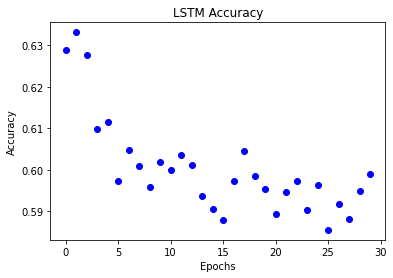

In [28]:
true, pred = val_loop(lstm_model, test_iterator)
print()
print(f"TEST F-1: {binary_macro_f1(true, pred)}")
print(f"TEST ACC: {accuracy(true, pred)}")
epochs = [range(0, TOTAL_EPOCHS)]
fig = plt.figure()
plt.title('LSTM Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.scatter(epochs, accuracy_plot, color = 'blue')
plt.show()